<a href="https://colab.research.google.com/github/wzh1998/CVPR-Learning/blob/main/3D_Geometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip uninstall opencv-python
!pip install opencv-contrib-python

     |████████████████████████████████| 56.4MB 75kB/s 


In [94]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [107]:
'''
Firstly, find as many possible matches between two images to find the fundamental 
matrix. For this, use SIFT descriptors with FLANN based matcher and ratio test.
'''
img1 = cv.imread('1.JPG',0)  #queryimage # left image
img2 = cv.imread('2.JPG',0) #trainimage # right image
sift = cv.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [108]:
'''
Visualization and check matches
'''
matchesMask = [[0, 0] for i in range(len(matches))]
# Draw the keypoint matches between both pictures
# Still based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask[300:500],
                   flags=cv.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv.drawMatchesKnn(
    img1, kp1, img2, kp2, matches[300:500], None, **draw_params)
cv.imwrite("vis.png", keypoint_matches)

True

In [109]:
from google.colab import files
files.download('vis.png') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [110]:
'''
After getting the list of best matches, find the fundamental matrix
'''
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [111]:
'''
Find the epilines. Epilines corresponding to the points in first image is drawn on second image. 
So mentioning of correct images are important here. We get an array of lines. 
So we define a new function to draw these lines on the images.
'''
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

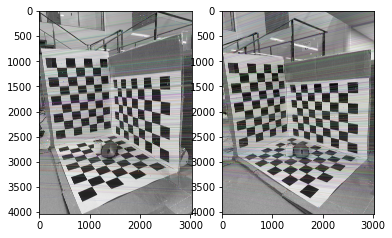

True

In [112]:
# Now we find the epilines in both the images and draw them.
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()
cv.imwrite("left.JPG", img5)
cv.imwrite("right.JPG", img3)



In [113]:
# Stereo rectification (uncalibrated variant)
# Adapted from: https://stackoverflow.com/a/62607343
fundamental_matrix = F
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

# Undistort (rectify) the images and save them
# Adapted from: https://stackoverflow.com/a/62607343
img1_rectified = cv.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv.warpPerspective(img2, H2, (w2, h2))
cv.imwrite("rectified_1.png", img1_rectified)
cv.imwrite("rectified_2.png", img2_rectified)

True

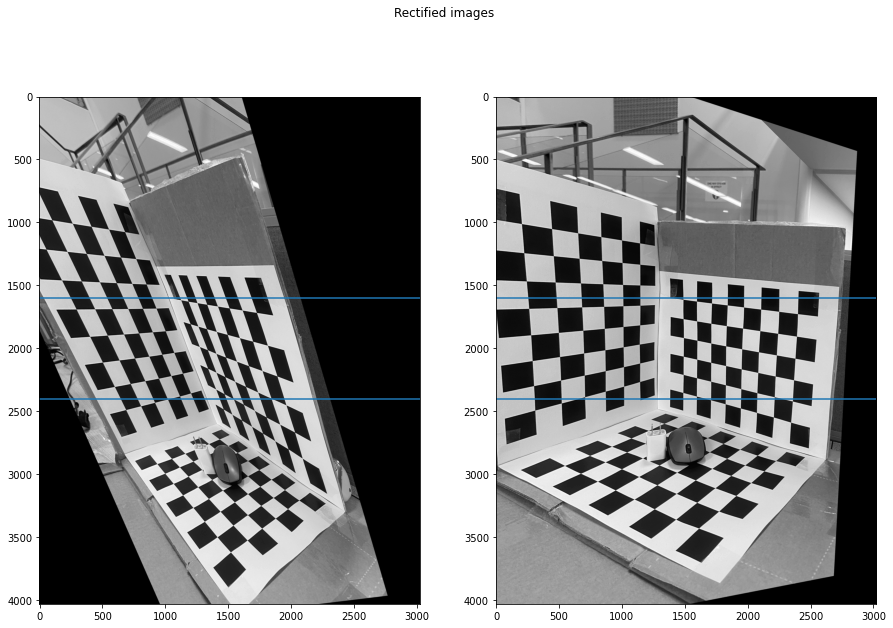

In [114]:
# Draw the rectified images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(1600)
axes[1].axhline(1600)
axes[0].axhline(2400)
axes[1].axhline(2400)
plt.suptitle("Rectified images")
plt.savefig("rectified_images.png")
plt.show()

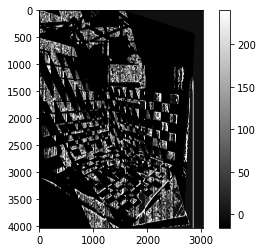

In [172]:
############## Calculate Disparity (Depth Map) ##############
# set retified images as inputs
# imgL_undistorted = img1_rectified
# imgR_undistorted = img1_rectified
imgL_undistorted = cv.imread('rectified_1.png',0)
imgR_undistorted = cv.imread('rectified_2.png',0)
# Using StereoBM
stereo = cv2.StereoSGBM_create(numDisparities=16, blockSize=27)
disparity_BM = stereo.compute(imgL_undistorted, imgR_undistorted)
plt.imshow(disparity_BM, "gray")
plt.colorbar()
plt.show()

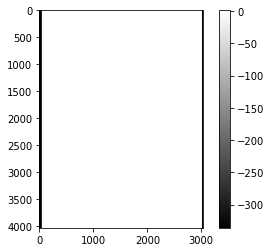

In [151]:

# Using StereoSGBM
# Set disparity parameters. Note: disparity range is tuned according to
#  specific parameters obtained through trial and error.
win_size = 2
min_disp = -4
max_disp = 9
num_disp = max_disp - min_disp  # Needs to be divisible by 16
stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=5,
    uniquenessRatio=5,
    speckleWindowSize=5,
    speckleRange=5,
    disp12MaxDiff=2,
    P1=8 * 3 * win_size ** 2,
    P2=32 * 3 * win_size ** 2,
)
disparity_SGBM = stereo.compute(imgL_undistorted, imgR_undistorted)
plt.imshow(disparity_SGBM, "gray")
plt.colorbar()
plt.show()